<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/ochuman_keypoint_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [OCHuman dataset](https://github.com/liruilong940607/OCHumanApi/tree/958aa2046ba4f5760fcc94cb458da8fe72cedf4f)

From the OCHuman repo:
> This dataset focus on heavily occluded human with comprehensive annotations including bounding-box, humans pose and instance mask. This dataset contains 13360 elaborately annotated human instances within 5081 images. With average 0.573 MaxIoU of each person, OCHuman is the most complex and challenging dataset related to human. Through this dataset, we want to emphasize occlusion as a challenging problem for researchers to study.


**Disclaimer**: it is currently not possible to run this notebook in Colab right away, given you need to download the OCHuman dataset manually. We advise running the notebook locally, as soon as you get access to the dataset.

## Installing IceVision

In [11]:
# Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# Choose your installation target: cuda11 or cuda10 or cpu
!bash icevision_install.sh cuda11

In [ ]:
# Restart kernel after installation
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

## Defining OCHuman parser

In [1]:
from icevision.all import *

_ = icedata.ochuman.load_data()

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /home/ubuntu/.icevision/mmdetection_configs/mmdetection_configs-2.16.0/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17
INFO     - 
    MANUALLY download AND unzip the dataset from https://cg.cs.tsinghua.edu.cn/dataset/form.html?dataset=ochuman. 
    You will need the path to the `ochuman.json` annotations file and the `images` directory.
     | icedata.datasets.ochuman.data:load_data:7


## Parse data

**Note**: you might need to change the `../../` path used from this point onwards, according to your filesystem (e.g. according to where you stored the dataset).

In [2]:
parser = icedata.ochuman.parser("../../OCHuman/ochuman.json", "../../OCHuman/images/")

train_records, valid_records = parser.parse(data_splitter=RandomSplitter([0.8, 0.2]),
                                            cache_filepath="../../OCHuman/ochuman.pkl")

INFO     - Loading cached records from ../../OCHuman/ochuman.pkl | icevision.parsers.parser:parse:113


In [3]:
len(train_records), len(valid_records)

(4064, 1017)

## Datasets + augmentations

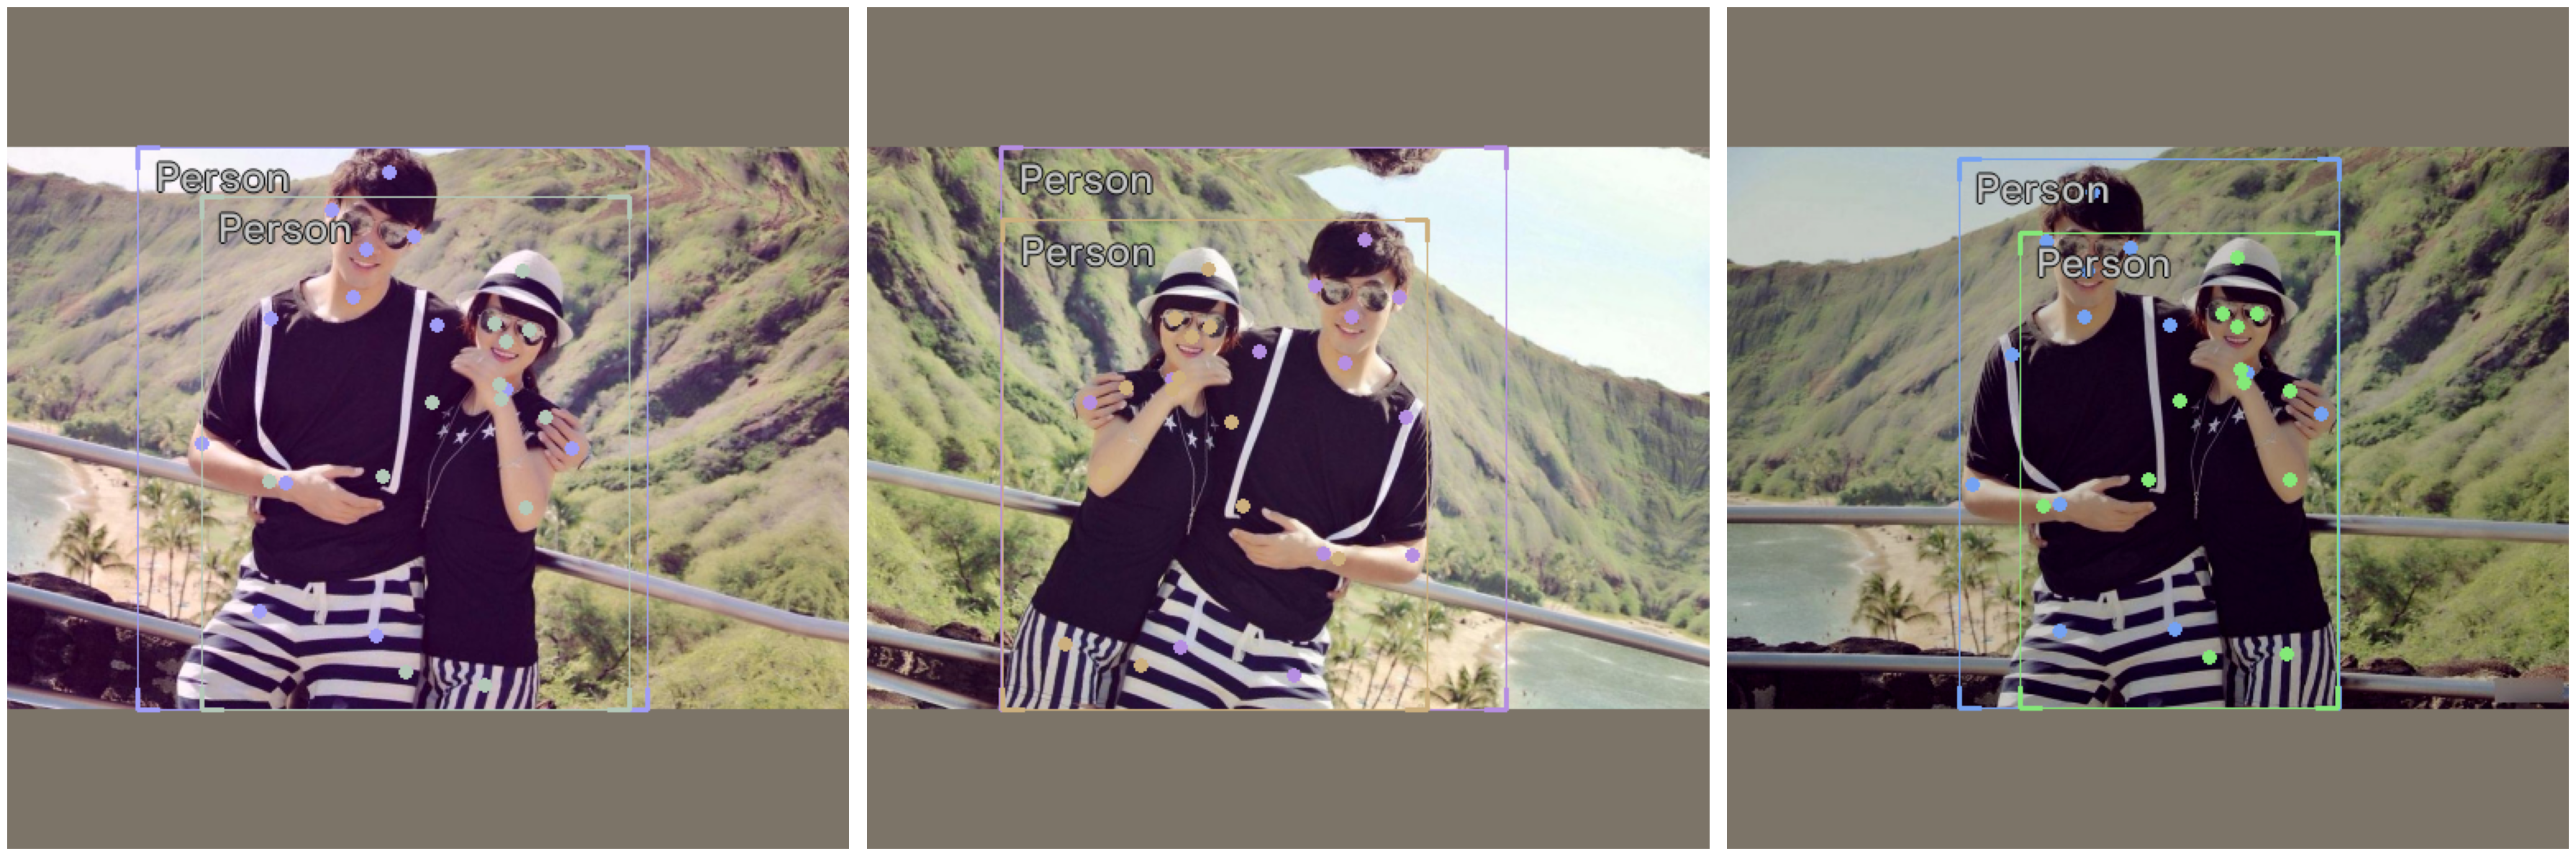

In [4]:
presize = 1024
size = 512

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize, crop_fn=None), tfms.A.Normalize()])

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

samples = [train_ds[1] for _ in range(3)]
show_samples(samples, ncols=3)

In [5]:
len(train_ds), len(valid_ds)

(4064, 1017)

## Dataloaders

In [6]:
model_type = models.torchvision.keypoint_rcnn

In [7]:
train_dl = model_type.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(train_ds, batch_size=16, num_workers=4, shuffle=False)

## Model

In [8]:
model = model_type.model(num_keypoints=19)

## Train a `fastai` learner

In [9]:
from fastai.callback.tracker import SaveModelCallback

In [10]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, cbs=[SaveModelCallback()])

/home/ubuntu/anaconda3/envs/ice/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


SuggestedLRs(valley=4.365158383734524e-05)

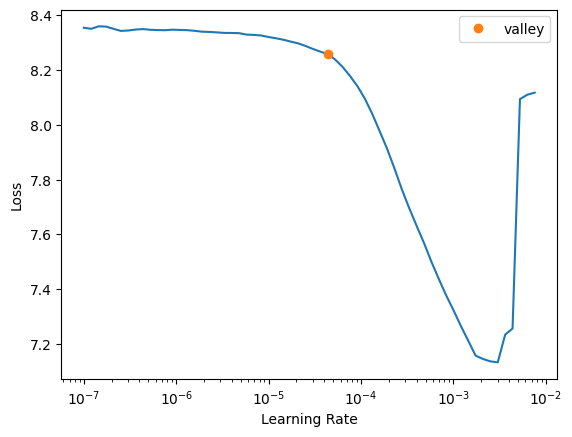

In [11]:
learn.lr_find()

In [12]:
learn.fine_tune(20, 3e-4, freeze_epochs=1)

Better model found at epoch 0 with valid_loss value: 4.609861373901367.


Better model found at epoch 0 with valid_loss value: 4.3073015213012695.
Better model found at epoch 1 with valid_loss value: 4.230605602264404.
Better model found at epoch 2 with valid_loss value: 4.1916022300720215.
Better model found at epoch 3 with valid_loss value: 4.123020648956299.
Better model found at epoch 4 with valid_loss value: 4.063462734222412.
Better model found at epoch 5 with valid_loss value: 4.037125110626221.
Better model found at epoch 6 with valid_loss value: 3.9523494243621826.
Better model found at epoch 7 with valid_loss value: 3.8758718967437744.
Better model found at epoch 8 with valid_loss value: 3.8188838958740234.
Better model found at epoch 9 with valid_loss value: 3.771754026412964.
Better model found at epoch 10 with valid_loss value: 3.699220657348633.
Better model found at epoch 11 with valid_loss value: 3.637545347213745.
Better model found at epoch 12 with valid_loss value: 3.561272144317627.
Better model found at epoch 13 with valid_loss value: 3.

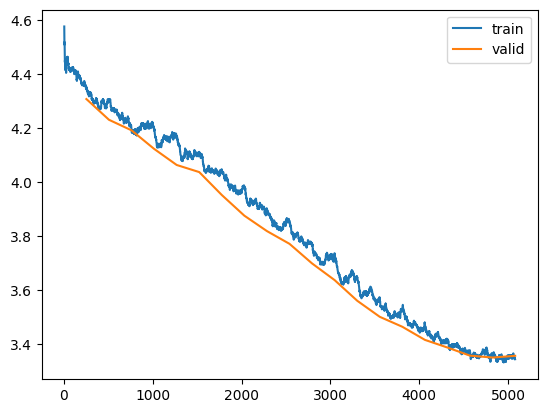

In [13]:
learn.recorder.plot_loss()

## Show model results

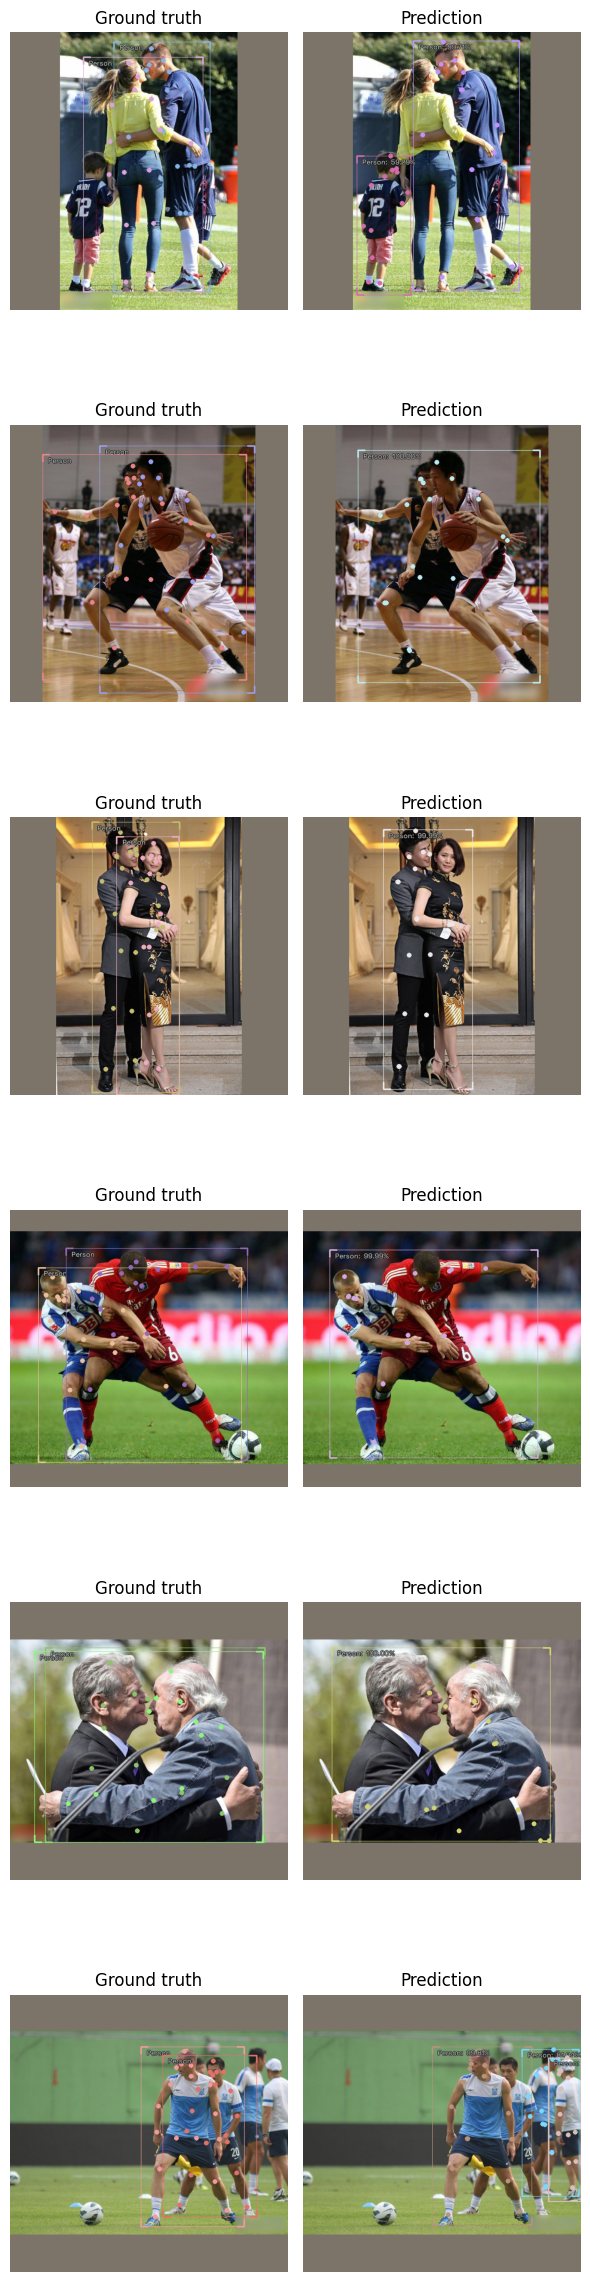

In [15]:
model_type.show_results(model, valid_ds)

## Save model

In [17]:
torch.save(model.state_dict(), "../../OCHuman/model.pth")

In [18]:
model = model_type.model(num_keypoints=19)
state_dict = torch.load("../../OCHuman/model.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

## Running inference on validation set

In [26]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=8)
preds = model_type.predict_from_dl(model=model, infer_dl=infer_dl, keep_images=True)

  0%|          | 0/128 [00:00<?, ?it/s]

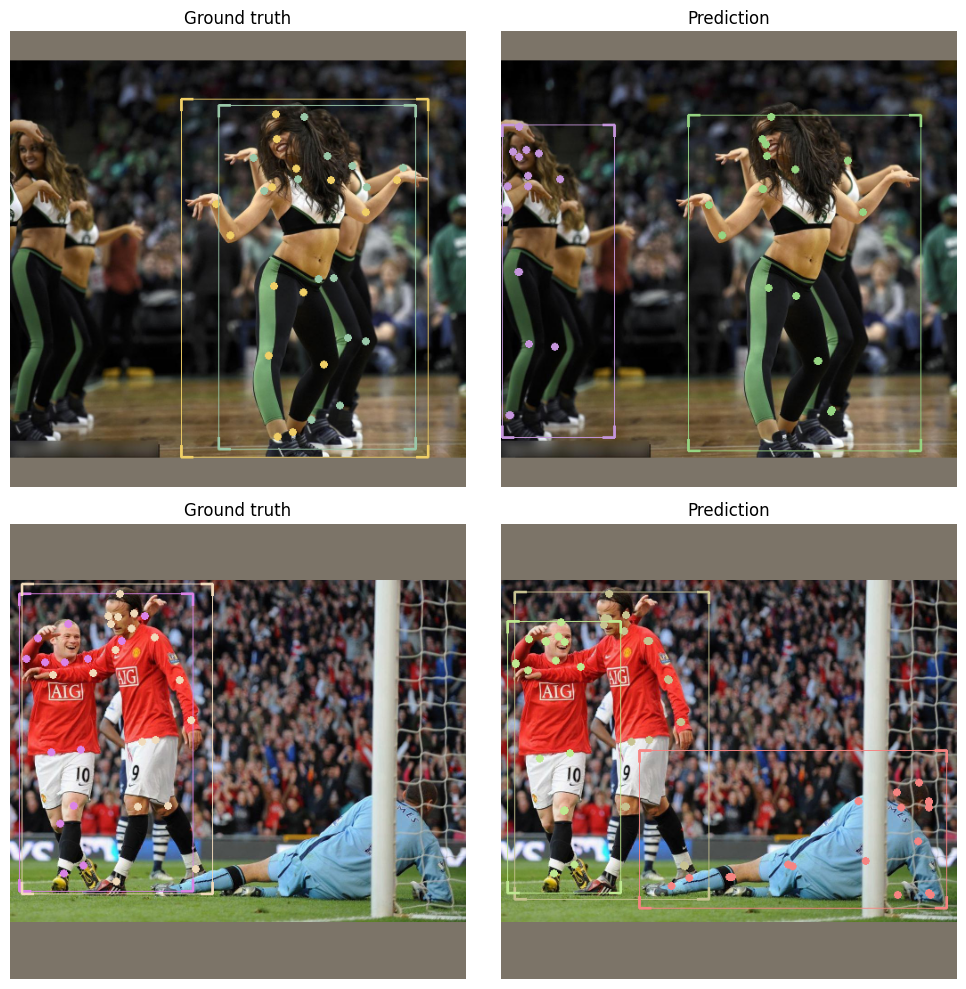

In [27]:
show_preds(preds=preds[68:70], show=True, display_label=False, figsize=(10, 10))

## `plot_top_losses`

INFO     - Losses returned by model: ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg', 'loss_keypoint'] | icevision.models.interpretation:plot_top_losses:218


  0%|          | 0/1017 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

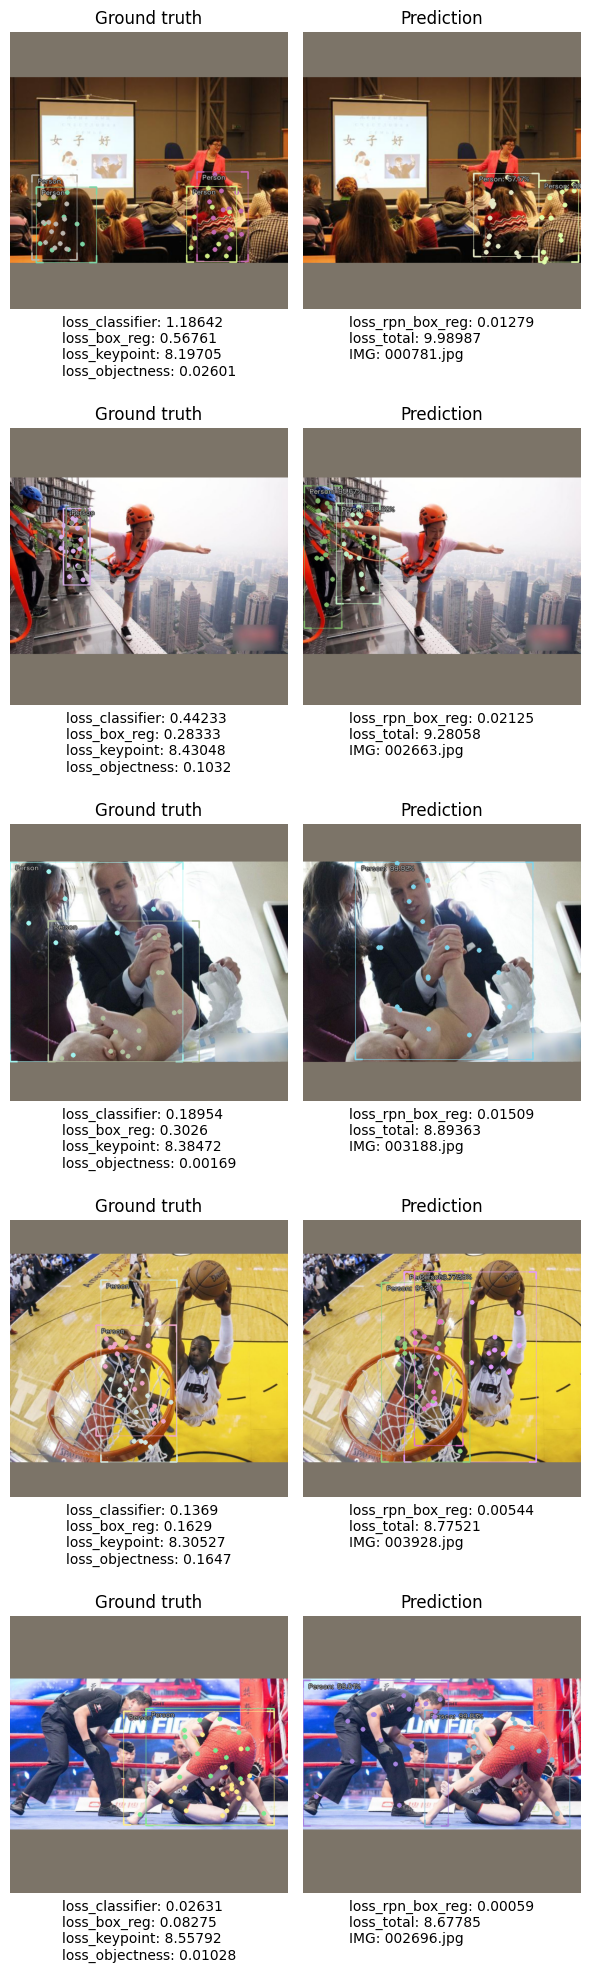

In [25]:
#model.train()
sorted_samples, sorted_preds, losses_stats = model_type.interp.plot_top_losses(model, valid_ds, 
                                                                                  sort_by="loss_total")